In [ ]:
from keras.models import load_model

# returns a compiled model
# identical to the previous one
model = load_model('/content/drive/MyDrive/model.h5',compile=False)


In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

In [ ]:
# Parameters used in the Dataset, on which YOLOv3 was pretrained
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the expected input shape for the model
WIDTH, HEIGHT = 416, 416

# define the probability threshold for detected objects
class_threshold = 0.3

In [ ]:
import os
from matplotlib import pyplot as plt
images = os.listdir('/content/drive/MyDrive/train_images')

In [ ]:
from numpy import expand_dims
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    '''
    Function preprocess the images to 416x416, which is the standard input shape for YOLOv3, 
    and also keeps track of the originl shape, which is later used to draw the boxes.
    
    paramters:
    filename {String}: path to the image
    shape {tuple}: shape of the input dimensions of the network
    
    returns:
    image {PIL}: image of shape 'shape'
    width {int}: original width of the picture
    height {int}: original height of the picture
    '''
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    
    # convert to numpy array
    image = img_to_array(image)
    
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

test host-a004_cam0_1232815254051064006.jpeg
car 99.95407462120056
car 57.97390341758728
truck 98.73436689376831
car 99.9143898487091
car 60.07440686225891
car 44.268253445625305
car 57.98952579498291
car 85.93178987503052
car 99.1256058216095


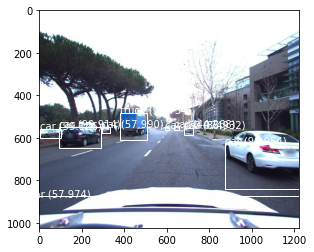

test host-a004_cam0_1232815257451064006.jpeg
car 69.52545642852783
truck 98.48707318305969
car 99.8570203781128
car 73.06963801383972
car 50.3038763999939
car 97.90943264961243


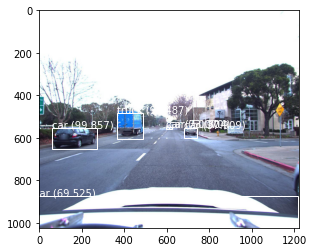

test host-a004_cam0_1231810077351067006.jpeg
car 75.11449456214905
car 65.09318351745605
car 63.95220160484314
car 74.66294169425964
car 33.58156681060791
car 98.8278329372406
car 96.45182490348816
car 96.55535221099854
car 98.5459566116333
car 99.87068772315979


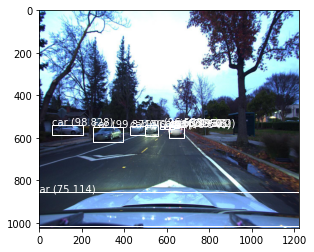

test host-a004_cam0_12318100773510670011.jpeg
car 97.42854833602905
car 97.57866859436035
bus 38.0124568939209
car 99.24113750457764
car 53.93194556236267
person 97.01640605926514
motorbike 93.69291067123413


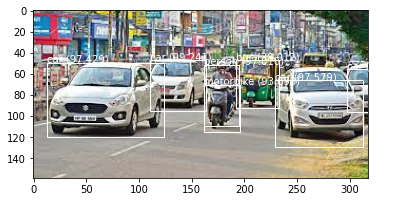

test host-a004_cam0_12318100773510670010.jpeg
bus 99.09225106239319
bus 84.28882360458374
bus 78.95496487617493
bus 73.85947108268738
truck 39.07361626625061
car 95.99572420120239
car 82.03074932098389
car 97.21776247024536
car 83.46558213233948
bus 68.8795268535614
car 67.15773940086365
bus 58.84680151939392
car 96.33535146713257
car 98.07799458503723
car 97.38416075706482
car 93.01357865333557
car 98.27842116355896
car 91.79651141166687
car 57.142817974090576
truck 33.367300033569336
car 92.75103211402893
car 52.30720639228821
car 30.20687699317932
car 70.06859183311462
car 70.19513845443726
car 31.561514735221863
car 42.59243607521057
car 64.25880193710327


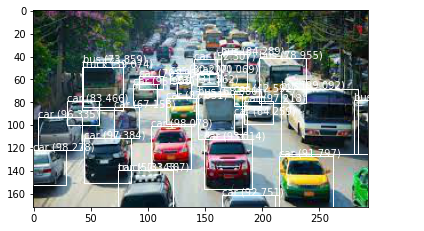

test host-a004_cam0_1231810077351067009.jpeg
car 98.95988702774048
bus 90.10144472122192
car 57.37653374671936
person 39.27503824234009
car 93.37778091430664
person 55.52314519882202
motorbike 38.858819007873535
person 49.87501800060272
person 57.65356421470642
bicycle 36.66357398033142
motorbike 54.97081279754639
motorbike 56.83049559593201
bicycle 30.177491903305054


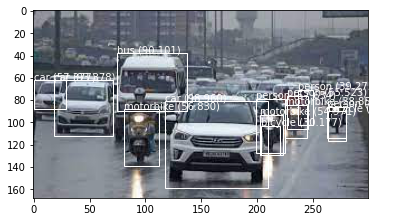

In [ ]:
for file in images:
    print("test",file)
    photo_filename = '/content/drive/MyDrive/' + 'train_images/' + file
    
    # load picture with old dimensions
    image, image_w, image_h = load_image_pixels(photo_filename, (WIDTH, HEIGHT))
    
    # Predict image
    yhat = model.predict(image)
    
    # Create boxes
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)

    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)

    # suppress non-maximal boxes
    do_nms(boxes, 0.5)

    # define the labels (Filtered only the ones relevant for this task, which were us retraining the YOLOv3 model)
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck","boat"]

    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

    # summarize what we found
    for i in range(len(v_boxes)):

        print(v_labels[i], v_scores[i])

    # draw what we found
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)
